<a href="https://colab.research.google.com/github/atp1988/gastrointestinal-polyp/blob/main/polyp_pytorch__1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/polyp/

/content/drive/MyDrive/polyp


# PVT Backbones

In [3]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.8 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from timm.models.vision_transformer import _cfg
from timm.models.registry import register_model

import math


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.dwconv = DWConv(hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = self.fc1(x)
        x = self.dwconv(x, H, W)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., sr_ratio=1):
        super().__init__()
        assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."

        self.dim = dim
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.kv = nn.Linear(dim, dim * 2, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv2d(dim, dim, kernel_size=sr_ratio, stride=sr_ratio)
            self.norm = nn.LayerNorm(dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        B, N, C = x.shape
        q = self.q(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        if self.sr_ratio > 1:
            x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
            x_ = self.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
            x_ = self.norm(x_)
            kv = self.kv(x_).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        else:
            kv = self.kv(x).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        k, v = kv[0], kv[1]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim,
            num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, sr_ratio=sr_ratio)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = x + self.drop_path(self.attn(self.norm1(x), H, W))
        x = x + self.drop_path(self.mlp(self.norm2(x), H, W))

        return x


class OverlapPatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)

        self.img_size = img_size
        self.patch_size = patch_size
        self.H, self.W = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))
        self.norm = nn.LayerNorm(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        return x, H, W


class PyramidVisionTransformerImpr(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dims=[64, 128, 256, 512],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1]):
        super().__init__()
        self.num_classes = num_classes
        self.depths = depths

        # patch_embed
        self.patch_embed1 = OverlapPatchEmbed(img_size=img_size, patch_size=7, stride=4, in_chans=in_chans,
                                              embed_dim=embed_dims[0])
        self.patch_embed2 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 16, patch_size=3, stride=2, in_chans=embed_dims[2],
                                              embed_dim=embed_dims[3])

        # transformer encoder
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule
        cur = 0
        self.block1 = nn.ModuleList([Block(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=mlp_ratios[0], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])
            for i in range(depths[0])])
        self.norm1 = norm_layer(embed_dims[0])

        cur += depths[0]
        self.block2 = nn.ModuleList([Block(
            dim=embed_dims[1], num_heads=num_heads[1], mlp_ratio=mlp_ratios[1], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[1])
            for i in range(depths[1])])
        self.norm2 = norm_layer(embed_dims[1])

        cur += depths[1]
        self.block3 = nn.ModuleList([Block(
            dim=embed_dims[2], num_heads=num_heads[2], mlp_ratio=mlp_ratios[2], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[2])
            for i in range(depths[2])])
        self.norm3 = norm_layer(embed_dims[2])

        cur += depths[2]
        self.block4 = nn.ModuleList([Block(
            dim=embed_dims[3], num_heads=num_heads[3], mlp_ratio=mlp_ratios[3], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[3])
            for i in range(depths[3])])
        self.norm4 = norm_layer(embed_dims[3])

        # classification head
        # self.head = nn.Linear(embed_dims[3], num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def init_weights(self, pretrained=None):
        if isinstance(pretrained, str):
            logger = 1
            #load_checkpoint(self, pretrained, map_location='cpu', strict=False, logger=logger)

    def reset_drop_path(self, drop_path_rate):
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(self.depths))]
        cur = 0
        for i in range(self.depths[0]):
            self.block1[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[0]
        for i in range(self.depths[1]):
            self.block2[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[1]
        for i in range(self.depths[2]):
            self.block3[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[2]
        for i in range(self.depths[3]):
            self.block4[i].drop_path.drop_prob = dpr[cur + i]

    def freeze_patch_emb(self):
        self.patch_embed1.requires_grad = False

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed1', 'pos_embed2', 'pos_embed3', 'pos_embed4', 'cls_token'}  # has pos_embed may be better

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    # def _get_pos_embed(self, pos_embed, patch_embed, H, W):
    #     if H * W == self.patch_embed1.num_patches:
    #         return pos_embed
    #     else:
    #         return F.interpolate(
    #             pos_embed.reshape(1, patch_embed.H, patch_embed.W, -1).permute(0, 3, 1, 2),
    #             size=(H, W), mode="bilinear").reshape(1, -1, H * W).permute(0, 2, 1)

    def forward_features(self, x):
        B = x.shape[0]
        outs = []

        # stage 1
        x, H, W = self.patch_embed1(x)
        for i, blk in enumerate(self.block1):
            x = blk(x, H, W)
        x = self.norm1(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 2
        x, H, W = self.patch_embed2(x)
        for i, blk in enumerate(self.block2):
            x = blk(x, H, W)
        x = self.norm2(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 3
        x, H, W = self.patch_embed3(x)
        for i, blk in enumerate(self.block3):
            x = blk(x, H, W)
        x = self.norm3(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 4
        x, H, W = self.patch_embed4(x)
        for i, blk in enumerate(self.block4):
            x = blk(x, H, W)
        x = self.norm4(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        return outs

        # return x.mean(dim=1)

    def forward(self, x):
        x = self.forward_features(x)
        # x = self.head(x)

        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)

        return x


def _conv_filter(state_dict, patch_size=16):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k:
            v = v.reshape((v.shape[0], 3, patch_size, patch_size))
        out_dict[k] = v

    return out_dict


@register_model
class pvt_v2_b0(PyramidVisionTransformerImpr):
    def __init__(self, **kwargs):
        super(pvt_v2_b0, self).__init__(
            patch_size=4, embed_dims=[32, 64, 160, 256], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)



@register_model
class pvt_v2_b1(PyramidVisionTransformerImpr):
    def __init__(self, **kwargs):
        super(pvt_v2_b1, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)

@register_model
class pvt_v2_b2(PyramidVisionTransformerImpr):
    def __init__(self, **kwargs):
        super(pvt_v2_b2, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)

@register_model
class pvt_v2_b3(PyramidVisionTransformerImpr):
    def __init__(self, **kwargs):
        super(pvt_v2_b3, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 4, 18, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)

@register_model
class pvt_v2_b4(PyramidVisionTransformerImpr):
    def __init__(self, **kwargs):
        super(pvt_v2_b4, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 8, 27, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)


@register_model
class pvt_v2_b5(PyramidVisionTransformerImpr):
    def __init__(self, **kwargs):
        super(pvt_v2_b5, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 6, 40, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)

#Polyp Net: PVT2 Backbone



In [5]:
class CAM(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(CAM, self).__init__()
        ## CA module
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

        ## SA module
        self.conv1 = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        x = self.sigmoid(out) * x

        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        y = torch.cat([avg_out, max_out], dim=1)
        y = self.conv1(y)

        return self.sigmoid(y) * x

class Attention_Gate(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_Gate,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi

class conv_block(nn.Module):
    def __init__(self, filter_in, filter_out, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(filter_in, filter_out, kernel_size=kernel_size, stride=stride, padding=padding)
        self.norm = nn.BatchNorm2d(filter_out, affine=False)
    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        return F.relu(x)

class fire_module(nn.Module):
    def __init__(self, filter_in, squeeze=16, expand=64):
        super().__init__()
        self.conv = conv_block(filter_in, squeeze, kernel_size=1, padding=0)
        self.left = conv_block(squeeze, expand, kernel_size=1, padding=0)
        self.right = conv_block(squeeze, expand, kernel_size=3, padding=1)
    def forward(self, x):
        x = self.conv(x)
        left = self.left(x)
        right = self.right(x)
        x = F.relu(torch.cat([left, right], 1))
        return nn.Upsample(scale_factor=2)(x)

In [6]:
class Polyp_Net(nn.Module):
    def __init__(self,
                 channels=[512,320,128,64],    ##-----> PVT-V2
                #  channels=[256, 160, 64, 32]  ## ---> PVT-V0
                 ):
        super(Polyp_Net ,self).__init__()

        self.backbone = pvt_v2_b2()
        path = '/content/drive/MyDrive/CASCADE/pretrained_pth/pvt/pvt_v2_b2.pth'
        save_model = torch.load(path)
        model_dict = self.backbone.state_dict()
        state_dict = {k: v for k, v in save_model.items() if k in model_dict.keys()}
        model_dict.update(state_dict)
        self.backbone.load_state_dict(model_dict)

        # self.backbone = pvt_v2_b0()

        # self.fire = fire_module(channels[0], channels[0]//8, channels[0]//2)  ## 512
        self.init_conv = conv_block(channels[0], channels[0], kernel_size=3, stride=1, padding=1) ## 512

        self.cam1 = CAM(in_planes=channels[0])
        self.fire1 = fire_module(channels[0], channels[0]//8, channels[1]//2)  ## 320
        # self.up1 = nn.Upsample(scale_factor=2)
        self.AG1 = Attention_Gate(F_g=channels[1],F_l=channels[1],F_int=channels[2])
###############

        self.cam2 = CAM(in_planes=2*channels[1])
        self.fire2 = fire_module(2*channels[1], 2*channels[1]//4, channels[2]//2)  ## 128
        # self.up2 = nn.Upsample(scale_factor=2)
        self.AG2 = Attention_Gate(F_g=channels[2],F_l=channels[2],F_int=channels[3])
###############

        self.cam3 = CAM(in_planes=2*channels[2])
        self.fire3 = fire_module(2*channels[2], 2*channels[2]//4, channels[3]//2)  ## 32
        # self.up3 = nn.Upsample(scale_factor=2)
        self.AG3 = Attention_Gate(F_g=channels[3],F_l=channels[3],F_int=32)
###############
        self.cam4 = CAM(in_planes=2*channels[3])
        self.conv4_1 = conv_block(2*channels[3], 2*channels[3], kernel_size=3, stride=1, padding=1)
        self.conv4_2 = conv_block(2*channels[3], 2*channels[3], kernel_size=3, stride=1, padding=1)
# ###############

        self.head1 = nn.Conv2d(channels[0], 1, kernel_size=1, padding=0)
        self.head2 = nn.Conv2d(2*channels[1], 1, kernel_size=1, padding=0)
        self.head3 = nn.Conv2d(2*channels[2], 1, kernel_size=1, padding=0)
        self.head4 = nn.Conv2d(2*channels[3], 1, kernel_size=1, padding=0)

    def forward(self, x):
        # backbone
        pvt = self.backbone(x)
        x1 = pvt[0]
        x2 = pvt[1]
        x3 = pvt[2] ## 20**20*128
        x4 = pvt[3] ## 10*10*256

        x = self.init_conv(x4)

        x = self.cam1(x)
        outcam1 = x
        x = self.fire1(x)
        x = torch.cat((x, self.AG1(x, x3)),dim=1)

        x = self.cam2(x)
        outcam2 = x
        x = self.fire2(x)
        x = torch.cat((x, self.AG2(x, x2)),dim=1)

        x = self.cam3(x)
        outcam3 = x
        x = self.fire3(x)
        x = torch.cat((x, self.AG3(x, x1)),dim=1)

        x = self.cam4(x)
        x = self.conv4_1(x)
        x = self.conv4_2(x)

        out1 = nn.Upsample(scale_factor=32)(self.head1(outcam1))
        out2 = nn.Upsample(scale_factor=16)(self.head2(outcam2))
        out3 = nn.Upsample(scale_factor=8)(self.head3(outcam3))
        out4 = nn.Upsample(scale_factor=4)(self.head4(x))

        output = (out1, out2, out3, out4)

        return output

In [ ]:
x = torch.randn((1, 3, 352, 352))
x.shape
Polyp_Net()(x)[2].shape

torch.Size([1, 1, 352, 352])

In [7]:
net = Polyp_Net()
sum(p.numel() for p in net.parameters() if p.requires_grad)

28082581

# Data Loader

In [ ]:
# img_size = (352, 352)
# batch_size = 10

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, transforms
from torchvision import transforms

import os
import cv2
from glob import glob
import numpy as np
import shutil
from PIL import Image
from matplotlib import pyplot as plt
import albumentations as A

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
# transform_train = A.Compose([
#     # A.Affine(scale=(1, 1.3), always_apply=False),
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.Affine(shear=(-45, 45), always_apply=False, p=0.5),
#     A.Affine(rotate=(-45, 45), always_apply=False, p=0.5),
#     # A.CLAHE(2.5, always_apply=False, p=0.5),
#     # A.RandomResizedCrop(height=img_size[0], width=img_size[1], p=.3, always_apply=False)

# ])

# transform_test = A.Compose([
#     # A.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
#     # A.Affine(scale=(1, 1.3), always_apply=False),
# ])

# totensor = transforms.Compose([transforms.ToTensor()])

class Polyp_Dataset(torch.utils.data.Dataset):

    def __init__(self, image_list, mask_list, transform, image_size):
        self.image_list = image_list
        self.mask_list = mask_list
        self.transform = transform
        self.image_size = image_size
    def __len__(self):
        return len(self.image_list)


    def _load_image(self, id):
        image_id = self.image_list[id]
        img = cv2.imread(image_id)
        img = cv2.resize(img, (self.image_size[1], self.image_size[0]))
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img, image_id

    def _load_mask(self, id):
        mask_id = self.mask_list[id]
        img = cv2.imread(mask_id)
        img = cv2.resize(img, (self.image_size[1], self.image_size[0]))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _,mask = cv2.threshold(gray,254,255,cv2.THRESH_BINARY)
        return np.expand_dims(mask, axis=-1), mask_id

    def _totensor(self, tensor):
        totensor = transforms.Compose([transforms.ToTensor()]) ## convert NHWC to NCHW and resacaled to [0,1]
        return totensor(tensor)

    def __getitem__(self, index: int):
        image, image_id = self._load_image(index)
        mask, mask_id = self._load_mask(index)

        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        # image = np.moveaxis(image, -1, 0)
        # mask = np.moveaxis(mask, -1, 0)
        # image = torch.tensor(image, dtype=torch.float32)
        # mask = torch.tensor(mask, dtype=torch.float32)
        # label = torch.tensor(label, dtype=torch.float32)

        image = self._totensor(image)
        mask = self._totensor(mask)

        return image, mask

In [ ]:
class DataLoader():
    def __init__(self, dataset_name, path, mode, transform, batch_size, image_size):
        self.dataset_name = dataset_name
        self.path = path
        self.mode = mode
        self.transform = transform
        self.batch_size = batch_size
        self.image_size = image_size

    def _transforms(self, status=None):
        if status == 'train':
            transform = A.Compose([
                # A.Affine(scale=(1, 1.3), always_apply=False),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.Affine(shear=(-45, 45), always_apply=False, p=0.5),
                A.Affine(rotate=(-45, 45), always_apply=False, p=0.5),
                # A.CLAHE(2.5, always_apply=False, p=0.5),
                # A.RandomResizedCrop(height=img_size[0], width=img_size[1], p=.3, always_apply=False)

            ])

        elif status == 'eval':
            transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                # A.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                # A.Affine(scale=(1, 1.3), always_apply=False),
            ])
        else:
            transform = A.Compose([
            ])

        return transform

    def create_loader(self):
        image_path = sorted(glob(self.path+self.dataset_name+'/images/*'))
        target_path = sorted(glob(self.path+self.dataset_name+'/masks/*'))
        if self.transform:
            transforms = self._transforms(status=self.mode)
            # if self.mode == 'train':
            #     print(f'transform on train set...')
            # elif self.mode == 'test':
            #     print(f'transform on val set...')
        else:
            transforms=None
            # print(f'transform skipped for {self.mode} set...')

        dataset = Polyp_Dataset(image_path, target_path, transforms, self.image_size)
        data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                                    batch_size=self.batch_size,
                                                    shuffle=True,
                                                    num_workers=1,
                                                    collate_fn=None,
                                                  )

        return data_loader

if __name__ == "__main__":
    test_datasets = ['test', 'CVC-300', 'CVC-ClinicDB', 'Kvasir', 'CVC-ColonDB', 'ETIS-LaribPolypDB']

    train_obj = DataLoader(dataset_name='',
                              path='../CASCADE/data/polyp/dataset/TrainDataset/',
                              mode='train',
                              transform = True,
                              batch_size=10,
                              image_size=(352,352))

    val_obj = DataLoader(dataset_name=test_datasets[0],
                              path='../CASCADE/data/polyp/dataset/TestDataset/',
                              mode='test',
                              transform = False,
                              batch_size=10,
                              image_size=(352,352))

    train_loader = train_obj.create_loader()
    val_loader = val_obj.create_loader()


In [ ]:
batch = next(iter(train_loader))
batch[0].shape, batch[1].shape

(torch.Size([10, 3, 352, 352]), torch.Size([10, 1, 352, 352]))

In [ ]:
torch.max(batch[0][0])

tensor(1.)

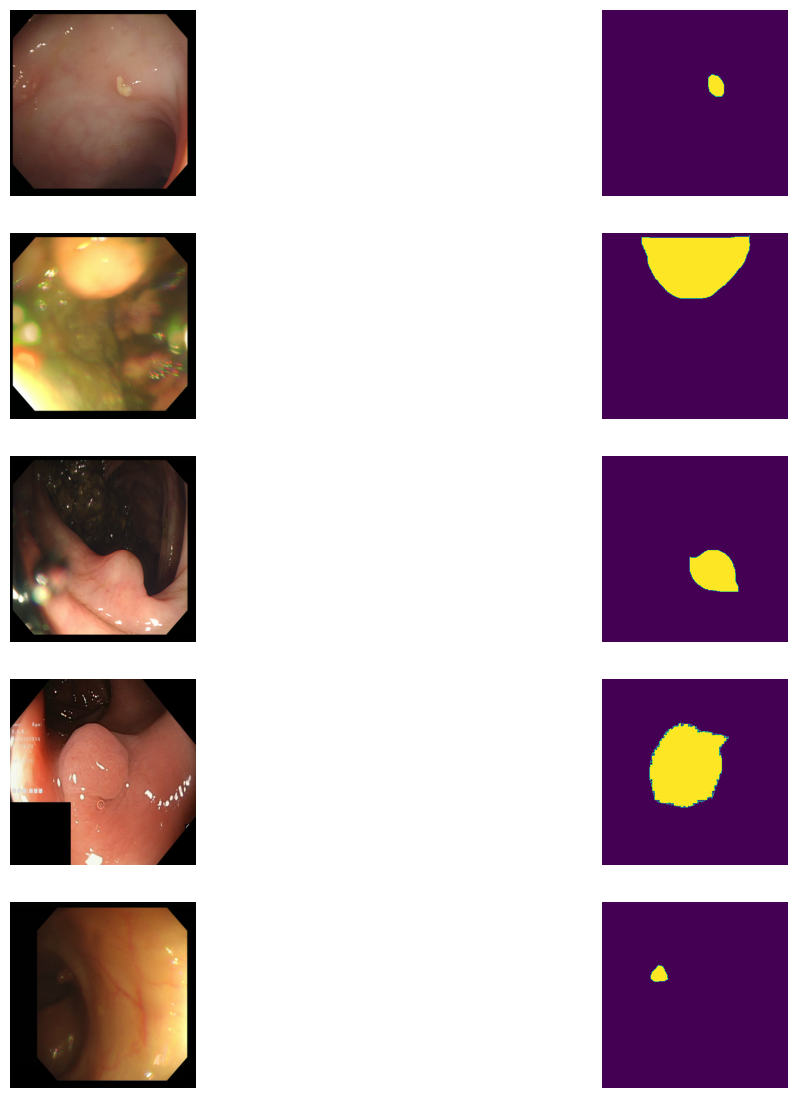

In [ ]:
batch = next(iter(val_loader))

plt.figure(figsize=(14, 14))
for i in range(5): ## batch
    for j in [0, 1]: ## image, mask
        if j==0:
            x = 2*i+1
        else:
            x = 2*i+2

        ax = plt.subplot(5,2, x)
        image = np.moveaxis(np.array(batch[j][i]*255), 0, -1)
        if j==0:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image.astype("uint8"))
        plt.axis("off")

# Color Mapping mask to image

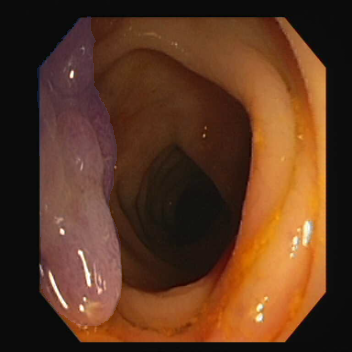

In [ ]:
import random
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

_classes_ = ['polyp']

COLORS = np.random.uniform(0, 255, size=(len(_classes_), 3))
# COLORS = np.array([[0, 255, 255]])
def draw_segmentation_map(image, mask):
    alpha = 1
    beta = 0.15 # transparency for the segmentation map
    gamma = .2 # scalar added to each sum

    red_map = np.zeros_like(mask).astype(np.uint8)
    green_map = np.zeros_like(mask).astype(np.uint8)
    blue_map = np.zeros_like(mask).astype(np.uint8)
    ## apply a randon color mask to each object
    color = COLORS[random.randrange(0, len(COLORS))]
    red_map[mask == 1], green_map[mask == 1], blue_map[mask == 1]  = color
    # combine all the masks into a single image
    segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
    ## convert from RGB to OpenCV BGR format
    # image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    ## apply mask on the image
    cv2.addWeighted(image, alpha, segmentation_map, beta, gamma, image)
    return image

if __name__ == '__main__':
    id=1
    image_path = train_img_path[id]
    mask_path  = train_target_path[id]
    image = cv2.imread(image_path)
    mask  = cv2.imread(mask_path)
    image = cv2.resize(image, img_size)
    mask = cv2.resize(mask, img_size)
    mask = mask[:, :, 0]
    mask = mask/255.
    result = draw_segmentation_map(image, mask)
    cv2_imshow(result)

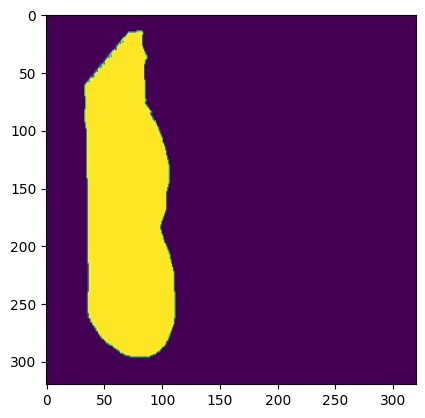

In [ ]:
plt.imshow(mask)

# Train Config

In [ ]:
!pip install torchmetrics
import torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 6.1 MB/s eta 0:00:00


In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
import sys
import torchmetrics
import logging
from torch.utils.tensorboard import SummaryWriter

logging.getLogger().setLevel(logging.INFO)
logger = logging.getLogger('Segmentation')
# logger.setLevel(logging.INFO)
writer = SummaryWriter()

In [ ]:
#PyTorch
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        ##comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class BCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(BCELoss, self).__init__()

    def forward(self, inputs, targets):

        ##comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        return BCE

#PyTorch
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        ##comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE


criterion_cls = BCELoss()
criterion_reg = DiceLoss()
criterion = DiceBCELoss()

optimizer = optim.AdamW(net.parameters(), lr=0.0005, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20000, eta_min=1e-6)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3,
                                           threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
get_lr(optimizer)

0.0005

In [ ]:
# from torchmetrics.classification import BinaryF1Score, BinaryPrecision, BinaryRecall
# from torchmetrics import Dice

# # Training
# def train(epoch):
#     net.train()
#     loss_reg_obj = AverageMeter()
#     loss_cls_obj = AverageMeter()
#     loss_total = AverageMeter()
#     Precision = BinaryPrecision().cuda()
#     Recall = BinaryRecall().cuda()
#     F1 = BinaryF1Score().cuda()
#     Dice_ = Dice().cuda()

#     for batch_idx, (inputs, masks) in enumerate(train_loader):
#         inputs, masks = inputs.to(device), masks.to(device)
#         optimizer.zero_grad()
#         masks_pred = net(inputs)
#         loss_reg = criterion_reg(masks_pred, masks)
#         loss_cls = criterion_cls(masks_pred, masks)
#         # loss = alpha*loss_reg + (1-alpha)*loss_cls
#         loss = loss_reg + loss_cls
#         loss.backward()
#         optimizer.step()

#         loss_total.update(loss)
#         loss_reg_obj.update(loss_reg)
#         loss_cls_obj.update(loss_cls)

#         Precision(masks_pred, masks)
#         Recall(masks_pred, masks)
#         F1(masks_pred, masks)
#         Dice_(masks_pred, masks.type(torch.int64))
#         # print(targets[:10])
#         # if batch_idx == 20:
#         #     break
#         # scheduler.step()
#     precision = Precision.compute()
#     recall = Recall.compute()
#     f1 = F1.compute()
#     dice = Dice_.compute()
#     # writer.add_scalar('Loss/train', loss_total.avg.item(), epoch)
#     # writer.add_scalar('Acc/train', acc.item(), epoch)

#     print(f'Train: Epoch:{epoch}',
#                 f'Loss:{loss_total.avg:.4}',
#                 f'Loss_reg:{loss_reg_obj.avg:0.4}',
#                 f'Loss_cls:{loss_cls_obj.avg:0.4}',
#                 f'Precision:{precision:0.4}',
#                 f'Recall:{recall:0.4}',
#                 f'F1:{f1:0.4}',
#                 f'Dice:{dice:0.4}')

# def validation(epoch, checkpoint):
#     net.eval()
#     val_loss_total = AverageMeter()
#     val_loss_reg_obj = AverageMeter()
#     val_loss_cls_obj = AverageMeter()
#     Precision = BinaryPrecision().cuda()
#     Recall = BinaryRecall().cuda()
#     F1 = BinaryF1Score().cuda()
#     Dice_ = Dice().cuda()

#     with torch.no_grad():
#         for batch_idx, (inputs, masks) in enumerate(val_loader):
#             inputs, masks = inputs.to(device), masks.to(device)
#             masks_pred = net(inputs)
#             val_loss_reg = criterion_reg(masks_pred, masks)
#             val_loss_cls = criterion_cls(masks_pred, masks)
#             val_loss = val_loss_reg + val_loss_cls
#             val_loss_total.update(val_loss)
#             val_loss_reg_obj.update(val_loss_reg)
#             val_loss_cls_obj.update(val_loss_cls)

#             Precision(masks_pred, masks)
#             Recall(masks_pred, masks)
#             F1(masks_pred, masks)
#             Dice_(masks_pred, masks.type(torch.int64))
#         val_precision = Precision.compute()
#         val_recall = Recall.compute()
#         val_f1 = F1.compute()
#         val_dice = Dice_.compute()

#         lr = scheduler.optimizer.param_groups[0]['lr']
#         scheduler.step(val_loss_total.avg)

#         # acc = accuracy.compute()
#         # writer.add_scalar('Loss/test', loss_total.avg.item(), epoch)
#         # writer.add_scalar('Acc/test', acc.item(), epoch)

#         print(f'Valid: Epoch:{epoch}',
#                     f'loss:{val_loss_total.avg:.4}',
#                     f'loss_reg:{val_loss_reg_obj.avg:0.4}',
#                     f'loss_cls:{val_loss_cls_obj.avg:0.4}',
#                     f'precision:{val_precision:0.4}',
#                     f'recall:{val_recall:0.4}',
#                     f'f1:{val_f1:0.4}',
#                     f'dice:{val_dice:0.4}',
#                     f'lr:{lr:0.1}')
#         print()


#     # Save checkpoint
#     checkpoint.save(val_f1, epoch=epoch)
#     # checkpoint.save(val_loss_total.avg, epoch=epoch)


# class Checkpoint(object):
#     def __init__(self, model_name):
#         '''acc = F1'''
#         self.best_acc = 0.
#         self.folder = 'checkpoint'
#         self.model_name = model_name
#         os.makedirs(self.folder, exist_ok=True)
#     def save(self, acc, epoch=-1):
#         if acc > self.best_acc:
#             logger.info('Saving checkpoint...')
#             state = {
#                 'net': net.state_dict(),
#                 'acc': acc,
#                 'epoch': epoch,
#             }
#             path = os.path.join(os.path.abspath(self.folder), self.model_name + '.pth')
#             torch.save(state, path)
#             self.best_acc = acc
#     def load(self, net):
#         pass

# Train lite model with backbone: PVT0

In [ ]:
from torchmetrics.classification import BinaryF1Score, BinaryPrecision, BinaryRecall
from torchmetrics import Dice

# Training
def train(epoch):
    net.train()
    loss_total = AverageMeter()
    Dice_ = Dice().cuda()

    for batch_idx, (inputs, masks) in enumerate(train_loader):
        inputs, masks = inputs.to(device), masks.to(device)
        optimizer.zero_grad()

        out1, out2, out3, out4 = net(inputs)

        loss1 = criterion(out1, masks)
        loss2 = criterion(out2, masks)
        loss3 = criterion(out3, masks)
        loss4 = criterion(out4, masks)

        a=1;b=1;c=1;d=1
        loss = a*loss1 + b*loss2 + c*loss3 + d*loss4

        loss.backward()
        optimizer.step()

        loss_total.update(loss)

        ## calculte Dice metric
        # out = F.upsample(out1 + out2 + out3 + out4, size=masks.shape, mode='bilinear', align_corners=False) # additive aggregation and upsampling
        out = out1 + out2 + out3 + out4
        out = F.sigmoid(out)
        out = (out - torch.min(out))/(torch.max(out)-torch.min(out))

        Dice_(out, masks.type(torch.int64))

    dice = Dice_.compute()
    # writer.add_scalar('Loss/train', loss_total.avg.item(), epoch)
    # writer.add_scalar('Acc/train', acc.item(), epoch)

    print(f'Train: Epoch[{epoch}]:',
                f'Loss:{loss_total.avg:.4}',
                f'Dice:{dice:0.4}')


def validation(epoch, checkpoint):
    net.eval()
    val_loss_total = AverageMeter()
    Dice_ = Dice().cuda()
    test_datasets = ['test', 'CVC-300', 'CVC-ClinicDB', 'Kvasir', 'CVC-ColonDB', 'ETIS-LaribPolypDB']

    for dataset_name in test_datasets:
        val_obj = DataLoader(dataset_name=dataset_name,
                                path='../CASCADE/data/polyp/dataset/TestDataset/',
                                mode='eval',
                                transform = False,
                                batch_size=10,
                                image_size=(352,352))

        val_loader = val_obj.create_loader()

        with torch.no_grad():
            for batch_idx, (inputs, masks) in enumerate(val_loader):
                inputs, masks = inputs.to(device), masks.to(device)
                out1, out2, out3, out4 = net(inputs)

                if dataset_name=='test':
                    loss1 = criterion(out1, masks)
                    loss2 = criterion(out2, masks)
                    loss3 = criterion(out3, masks)
                    loss4 = criterion(out4, masks)

                    a=1;b=1;c=1;d=1
                    val_loss = a*loss1 + b*loss2 + c*loss3 + d*loss4
                    val_loss_total.update(val_loss)

                # out = F.upsample(out1 + out2 + out3 + out4, size=masks.shape, mode='bilinear', align_corners=False)
                out = out1 + out2 + out3 + out4
                out = F.sigmoid(out)
                out = (out - torch.min(out))/(torch.max(out)-torch.min(out))

                Dice_(out, masks.type(torch.int64))

            val_dice = Dice_.compute()

            if dataset_name=='test':
                checkpoint.save(val_dice, epoch=epoch)
                lr = scheduler.optimizer.param_groups[0]['lr']
                print(f'Valid: Epoch[{epoch}]:',
                            f'loss:{val_loss_total.avg:.4}',
                            f'Dice:{val_dice:0.4}',
                            f'lr:{lr:0.1}',
                     )


            else:
                print(f'Dice [{dataset_name}]:{val_dice:0.4}')

    print()
    scheduler.step(val_loss_total.avg)



class Checkpoint(object):
    def __init__(self, model_name):
        '''acc = Dice'''
        self.best_acc = 0.
        self.folder = 'checkpoint'
        self.model_name = model_name
        os.makedirs(self.folder, exist_ok=True)
    def save(self, acc, epoch=-1):
        if acc > self.best_acc:
            logger.info('Saving checkpoint...')
            state = {
                'net': net.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            path = os.path.join(os.path.abspath(self.folder), self.model_name + '.pth')
            torch.save(state, path)
            self.best_acc = acc
    def load(self, net):
        pass

In [ ]:
# writer = SummaryWriter()
checkpoint = Checkpoint('ckpt_pvt0')
# alpha=0.5
start, end = 1, 30
net = net.to(device)
for epoch in range(start, end):
    train(epoch)
    validation(epoch, checkpoint)
# writer.close()

Train: Epoch[1]: Loss:3.767 Dice:0.4264


INFO:Segmentation:Saving checkpoint...


Valid: Epoch[1]: loss:4.612 Dice:0.315 lr:0.0005
Dice [CVC-300]:0.3076
Dice [CVC-ClinicDB]:0.3151
Dice [Kvasir]:0.3423
Dice [CVC-ColonDB]:0.3296
Dice [ETIS-LaribPolypDB]:0.315

Train: Epoch[2]: Loss:3.341 Dice:0.5143
Valid: Epoch[2]: loss:3.927 Dice:0.3022 lr:0.0005
Dice [CVC-300]:0.3061
Dice [CVC-ClinicDB]:0.3142
Dice [Kvasir]:0.3328
Dice [CVC-ColonDB]:0.3097
Dice [ETIS-LaribPolypDB]:0.3022

Train: Epoch[3]: Loss:3.043 Dice:0.5618


INFO:Segmentation:Saving checkpoint...


Valid: Epoch[3]: loss:3.662 Dice:0.3671 lr:0.0005
Dice [CVC-300]:0.3694
Dice [CVC-ClinicDB]:0.3812
Dice [Kvasir]:0.4006
Dice [CVC-ColonDB]:0.3768
Dice [ETIS-LaribPolypDB]:0.3671

Train: Epoch[4]: Loss:2.923 Dice:0.5859


INFO:Segmentation:Saving checkpoint...


Valid: Epoch[4]: loss:3.456 Dice:0.4273 lr:0.0005
Dice [CVC-300]:0.4268
Dice [CVC-ClinicDB]:0.4403
Dice [Kvasir]:0.4645
Dice [CVC-ColonDB]:0.4423
Dice [ETIS-LaribPolypDB]:0.4273

Train: Epoch[5]: Loss:2.806 Dice:0.6036
Valid: Epoch[5]: loss:3.435 Dice:0.4135 lr:0.0005
Dice [CVC-300]:0.4178
Dice [CVC-ClinicDB]:0.4291
Dice [Kvasir]:0.4552
Dice [CVC-ColonDB]:0.4298
Dice [ETIS-LaribPolypDB]:0.4135

Train: Epoch[6]: Loss:2.598 Dice:0.6375


INFO:Segmentation:Saving checkpoint...


Valid: Epoch[6]: loss:3.369 Dice:0.4974 lr:0.0005
Dice [CVC-300]:0.4953
Dice [CVC-ClinicDB]:0.505
Dice [Kvasir]:0.5348
Dice [CVC-ColonDB]:0.5181
Dice [ETIS-LaribPolypDB]:0.4974

Train: Epoch[7]: Loss:2.483 Dice:0.6592


INFO:Segmentation:Saving checkpoint...


Valid: Epoch[7]: loss:2.929 Dice:0.5308 lr:0.0005
Dice [CVC-300]:0.5332
Dice [CVC-ClinicDB]:0.5385
Dice [Kvasir]:0.5567
Dice [CVC-ColonDB]:0.5356
Dice [ETIS-LaribPolypDB]:0.5308

Train: Epoch[8]: Loss:2.375 Dice:0.6726


INFO:Segmentation:Saving checkpoint...


Valid: Epoch[8]: loss:3.043 Dice:0.5334 lr:0.0005
Dice [CVC-300]:0.5309
Dice [CVC-ClinicDB]:0.5424
Dice [Kvasir]:0.572
Dice [CVC-ColonDB]:0.5487
Dice [ETIS-LaribPolypDB]:0.5334

Train: Epoch[9]: Loss:2.349 Dice:0.6791


INFO:Segmentation:Saving checkpoint...


Valid: Epoch[9]: loss:2.753 Dice:0.5775 lr:0.0005
Dice [CVC-300]:0.5773
Dice [CVC-ClinicDB]:0.5865
Dice [Kvasir]:0.6103
Dice [CVC-ColonDB]:0.5855
Dice [ETIS-LaribPolypDB]:0.5775

Train: Epoch[10]: Loss:2.276 Dice:0.6879
Valid: Epoch[10]: loss:2.9 Dice:0.5687 lr:0.0005
Dice [CVC-300]:0.5706
Dice [CVC-ClinicDB]:0.5807
Dice [Kvasir]:0.6086
Dice [CVC-ColonDB]:0.585
Dice [ETIS-LaribPolypDB]:0.5687

Train: Epoch[11]: Loss:2.143 Dice:0.7106
Valid: Epoch[11]: loss:2.986 Dice:0.5558 lr:0.0005
Dice [CVC-300]:0.5539
Dice [CVC-ClinicDB]:0.5646
Dice [Kvasir]:0.5935
Dice [CVC-ColonDB]:0.5708
Dice [ETIS-LaribPolypDB]:0.5558

Train: Epoch[12]: Loss:2.152 Dice:0.707


INFO:Segmentation:Saving checkpoint...


Valid: Epoch[12]: loss:2.716 Dice:0.5938 lr:0.0005
Dice [CVC-300]:0.5942
Dice [CVC-ClinicDB]:0.6027
Dice [Kvasir]:0.6315
Dice [CVC-ColonDB]:0.6107
Dice [ETIS-LaribPolypDB]:0.5938

Train: Epoch[13]: Loss:2.101 Dice:0.7143


INFO:Segmentation:Saving checkpoint...


Valid: Epoch[13]: loss:2.456 Dice:0.6299 lr:0.0005
Dice [CVC-300]:0.6316
Dice [CVC-ClinicDB]:0.6388
Dice [Kvasir]:0.6637
Dice [CVC-ColonDB]:0.6335
Dice [ETIS-LaribPolypDB]:0.6299

Train: Epoch[14]: Loss:2.08 Dice:0.7186


INFO:Segmentation:Saving checkpoint...


Valid: Epoch[14]: loss:2.45 Dice:0.6404 lr:0.0005
Dice [CVC-300]:0.642
Dice [CVC-ClinicDB]:0.6496
Dice [Kvasir]:0.6701
Dice [CVC-ColonDB]:0.6478
Dice [ETIS-LaribPolypDB]:0.6404

Train: Epoch[15]: Loss:1.997 Dice:0.7319
Valid: Epoch[15]: loss:2.368 Dice:0.6392 lr:0.0005
Dice [CVC-300]:0.6402
Dice [CVC-ClinicDB]:0.6481
Dice [Kvasir]:0.6686
Dice [CVC-ColonDB]:0.6408
Dice [ETIS-LaribPolypDB]:0.6392

Train: Epoch[16]: Loss:1.938 Dice:0.7419
Valid: Epoch[16]: loss:2.746 Dice:0.5932 lr:0.0005
Dice [CVC-300]:0.5953
Dice [CVC-ClinicDB]:0.604
Dice [Kvasir]:0.6286
Dice [CVC-ColonDB]:0.6187
Dice [ETIS-LaribPolypDB]:0.5932

Train: Epoch[17]: Loss:1.935 Dice:0.745
Valid: Epoch[17]: loss:2.387 Dice:0.6378 lr:0.0005
Dice [CVC-300]:0.6399
Dice [CVC-ClinicDB]:0.6483
Dice [Kvasir]:0.6692
Dice [CVC-ColonDB]:0.6404
Dice [ETIS-LaribPolypDB]:0.6378

Train: Epoch[18]: Loss:1.887 Dice:0.7498
Valid: Epoch[18]: loss:2.374 Dice:0.6326 lr:0.0005
Dice [CVC-300]:0.6369
Dice [CVC-ClinicDB]:0.6445
Dice [Kvasir]:0.668


INFO:Segmentation:Saving checkpoint...


Valid: Epoch[20]: loss:2.334 Dice:0.6582 lr:0.0001
Dice [CVC-300]:0.6585
Dice [CVC-ClinicDB]:0.6657
Dice [Kvasir]:0.6925
Dice [CVC-ColonDB]:0.6702
Dice [ETIS-LaribPolypDB]:0.6582

Train: Epoch[21]: Loss:1.664 Dice:0.785


INFO:Segmentation:Saving checkpoint...


Valid: Epoch[21]: loss:2.22 Dice:0.6769 lr:0.0001
Dice [CVC-300]:0.6784
Dice [CVC-ClinicDB]:0.6849
Dice [Kvasir]:0.7085
Dice [CVC-ColonDB]:0.6834
Dice [ETIS-LaribPolypDB]:0.6769

Train: Epoch[22]: Loss:1.627 Dice:0.7877
Valid: Epoch[22]: loss:2.215 Dice:0.6749 lr:0.0001
Dice [CVC-300]:0.6776
Dice [CVC-ClinicDB]:0.6842
Dice [Kvasir]:0.708
Dice [CVC-ColonDB]:0.6793
Dice [ETIS-LaribPolypDB]:0.6749

Train: Epoch[23]: Loss:1.596 Dice:0.7942
Valid: Epoch[23]: loss:2.286 Dice:0.6652 lr:0.0001
Dice [CVC-300]:0.6676
Dice [CVC-ClinicDB]:0.6752
Dice [Kvasir]:0.6988
Dice [CVC-ColonDB]:0.6742
Dice [ETIS-LaribPolypDB]:0.6652

Train: Epoch[24]: Loss:1.621 Dice:0.7881


INFO:Segmentation:Saving checkpoint...


Valid: Epoch[24]: loss:2.174 Dice:0.6788 lr:0.0001
Dice [CVC-300]:0.6793
Dice [CVC-ClinicDB]:0.6859
Dice [Kvasir]:0.7078
Dice [CVC-ColonDB]:0.6842
Dice [ETIS-LaribPolypDB]:0.6788

Train: Epoch[25]: Loss:1.577 Dice:0.7982
Valid: Epoch[25]: loss:2.335 Dice:0.6673 lr:0.0001
Dice [CVC-300]:0.6687
Dice [CVC-ClinicDB]:0.6759
Dice [Kvasir]:0.7009
Dice [CVC-ColonDB]:0.6793
Dice [ETIS-LaribPolypDB]:0.6673

Train: Epoch[26]: Loss:1.554 Dice:0.7985
Valid: Epoch[26]: loss:2.354 Dice:0.6542 lr:0.0001
Dice [CVC-300]:0.6548
Dice [CVC-ClinicDB]:0.6637
Dice [Kvasir]:0.6891
Dice [CVC-ColonDB]:0.6686
Dice [ETIS-LaribPolypDB]:0.6542

Train: Epoch[27]: Loss:1.588 Dice:0.7977
Valid: Epoch[27]: loss:2.241 Dice:0.6669 lr:0.0001
Dice [CVC-300]:0.6685
Dice [CVC-ClinicDB]:0.6766
Dice [Kvasir]:0.6987
Dice [CVC-ColonDB]:0.6723
Dice [ETIS-LaribPolypDB]:0.6669

Train: Epoch[28]: Loss:1.563 Dice:0.7981
Valid: Epoch[28]: loss:2.25 Dice:0.6717 lr:0.0001
Dice [CVC-300]:0.6716
Dice [CVC-ClinicDB]:0.6798
Dice [Kvasir]:0.7

# Train model with backbone: PVT2

In [ ]:
def structure_loss(pred, mask):
    weit = 1 + 5 * torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15) - mask)
    wbce = F.binary_cross_entropy_with_logits(pred, mask, reduce='none')
    wbce = (weit * wbce).sum(dim=(2, 3)) / weit.sum(dim=(2, 3))

    pred = torch.sigmoid(pred)
    inter = ((pred * mask) * weit).sum(dim=(2, 3))
    union = ((pred + mask) * weit).sum(dim=(2, 3))
    wiou = 1 - (inter + 1) / (union - inter + 1)

    return torch.mean(wbce + wiou)

In [ ]:
optimizer = optim.AdamW(net.parameters(), lr=0.0005, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3,
                                           threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)

In [ ]:
def clip_gradient(optimizer, grad_clip):
    """
    For calibrating misalignment gradient via cliping gradient technique
    :param optimizer:
    :param grad_clip:
    :return:
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

In [ ]:
from torchmetrics.classification import BinaryF1Score, BinaryPrecision, BinaryRecall
from torchmetrics import Dice

# Training
def train(epoch):
    net.train()
    loss_total = AverageMeter()
    Dice_ = Dice().cuda()

    for batch_idx, (inputs, masks) in enumerate(train_loader):
        inputs, masks = inputs.to(device), masks.to(device)
        optimizer.zero_grad()

        out1, out2, out3, out4 = net(inputs)

        # loss1 = criterion(out1, masks)
        # loss2 = criterion(out2, masks)
        # loss3 = criterion(out3, masks)
        # loss4 = criterion(out4, masks)

        loss1 = structure_loss(out1, masks)
        loss2 = structure_loss(out2, masks)
        loss3 = structure_loss(out3, masks)
        loss4 = structure_loss(out4, masks)

        a=1;b=1;c=1;d=1
        loss = a*loss1 + b*loss2 + c*loss3 + d*loss4

        loss.backward()
        clip_gradient(optimizer, 0.5)
        optimizer.step()

        loss_total.update(loss)

        ## calculte Dice metric
        # out = F.upsample(out1 + out2 + out3 + out4, size=masks.shape, mode='bilinear', align_corners=False) # additive aggregation and upsampling
        out = out1 + out2 + out3 + out4
        out = F.sigmoid(out)
        out = (out - torch.min(out))/(torch.max(out)-torch.min(out))

        Dice_(out, masks.type(torch.int64))

    dice = Dice_.compute()

    print(f'Train: Epoch[{epoch}]:',
                f'Loss:{loss_total.avg:.4}',
                f'Dice:{dice:0.4}')


def validation(epoch, checkpoint):
    net.eval()
    val_loss_total = AverageMeter()
    Dice_ = Dice().cuda()
    test_datasets = ['test', 'CVC-300', 'CVC-ClinicDB', 'Kvasir', 'CVC-ColonDB', 'ETIS-LaribPolypDB']

    for dataset_name in test_datasets:
        val_obj = DataLoader(dataset_name=dataset_name,
                                path='../CASCADE/data/polyp/dataset/TestDataset/',
                                mode='eval',
                                transform = False,
                                batch_size=10,
                                image_size=(352,352))

        val_loader = val_obj.create_loader()

        with torch.no_grad():
            for batch_idx, (inputs, masks) in enumerate(val_loader):
                inputs, masks = inputs.to(device), masks.to(device)
                out1, out2, out3, out4 = net(inputs)

                if dataset_name=='test':
                    # loss1 = criterion(out1, masks)
                    # loss2 = criterion(out2, masks)
                    # loss3 = criterion(out3, masks)
                    # loss4 = criterion(out4, masks)

                    loss1 = structure_loss(out1, masks)
                    loss2 = structure_loss(out2, masks)
                    loss3 = structure_loss(out3, masks)
                    loss4 = structure_loss(out4, masks)

                    a=1;b=1;c=1;d=1
                    val_loss = a*loss1 + b*loss2 + c*loss3 + d*loss4
                    val_loss_total.update(val_loss)

                # out = F.upsample(out1 + out2 + out3 + out4, size=masks.shape, mode='bilinear', align_corners=False)
                out = out1 + out2 + out3 + out4
                out = F.sigmoid(out)
                out = (out - torch.min(out))/(torch.max(out)-torch.min(out))

                Dice_(out, masks.type(torch.int64))

            val_dice = Dice_.compute()

            if dataset_name=='test':
                checkpoint.save(val_dice, epoch=epoch)
                lr = scheduler.optimizer.param_groups[0]['lr']
                print(f'Valid: Epoch[{epoch}]:',
                            f'loss:{val_loss_total.avg:.4}',
                            f'Dice:{val_dice:0.4}',
                            f'lr:{lr:0.1}',
                     )


            else:
                print(f'Dice [{dataset_name}]:{val_dice:0.4}')

    print()
    scheduler.step(val_loss_total.avg)



class Checkpoint(object):
    def __init__(self, model_name):
        '''acc = Dice'''
        self.best_acc = 0.
        self.folder = 'checkpoint'
        self.model_name = model_name
        os.makedirs(self.folder, exist_ok=True)
    def save(self, acc, epoch=-1):
        if acc > self.best_acc:
            logger.info('Saving checkpoint...')
            state = {
                'net': net.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            path = os.path.join(os.path.abspath(self.folder), self.model_name + '.pth')
            torch.save(state, path)
            self.best_acc = acc
    def load(self, net):
        pass

In [ ]:
# writer = SummaryWriter()
checkpoint = Checkpoint('ckpt_pvt2')
# alpha=0.5
start, end = 1, 50
net = net.to(device)
for epoch in range(start, end):
    train(epoch)
    validation(epoch, checkpoint)
# writer.close()

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Train: Epoch[1]: Loss:4.237 Dice:0.4814


INFO:Segmentation:Saving checkpoint...


Valid: Epoch[1]: loss:4.013 Dice:0.4878 lr:0.0005
Dice [CVC-300]:0.4845
Dice [CVC-ClinicDB]:0.4892
Dice [Kvasir]:0.5135
Dice [CVC-ColonDB]:0.5021
Dice [ETIS-LaribPolypDB]:0.4878

Train: Epoch[2]: Loss:2.936 Dice:0.6996


INFO:Segmentation:Saving checkpoint...


Valid: Epoch[2]: loss:2.929 Dice:0.6516 lr:0.0005
Dice [CVC-300]:0.6509
Dice [CVC-ClinicDB]:0.6565
Dice [Kvasir]:0.6768
Dice [CVC-ColonDB]:0.6549
Dice [ETIS-LaribPolypDB]:0.6516

Train: Epoch[3]: Loss:2.618 Dice:0.7496


INFO:Segmentation:Saving checkpoint...


Valid: Epoch[3]: loss:2.717 Dice:0.6864 lr:0.0005
Dice [CVC-300]:0.6875
Dice [CVC-ClinicDB]:0.6925
Dice [Kvasir]:0.71
Dice [CVC-ColonDB]:0.6917
Dice [ETIS-LaribPolypDB]:0.6864

Train: Epoch[4]: Loss:2.481 Dice:0.7687
Valid: Epoch[4]: loss:2.724 Dice:0.6557 lr:0.0005
Dice [CVC-300]:0.6561
Dice [CVC-ClinicDB]:0.6586
Dice [Kvasir]:0.6836
Dice [CVC-ColonDB]:0.6716
Dice [ETIS-LaribPolypDB]:0.6557

Train: Epoch[5]: Loss:2.327 Dice:0.7935
Valid: Epoch[5]: loss:2.842 Dice:0.5925 lr:0.0005
Dice [CVC-300]:0.5984
Dice [CVC-ClinicDB]:0.6061
Dice [Kvasir]:0.6204
Dice [CVC-ColonDB]:0.595
Dice [ETIS-LaribPolypDB]:0.5925

Train: Epoch[6]: Loss:2.257 Dice:0.8028


INFO:Segmentation:Saving checkpoint...


Valid: Epoch[6]: loss:2.598 Dice:0.7015 lr:0.0005
Dice [CVC-300]:0.7042
Dice [CVC-ClinicDB]:0.7096
Dice [Kvasir]:0.7309
Dice [CVC-ColonDB]:0.6996
Dice [ETIS-LaribPolypDB]:0.7015

Train: Epoch[7]: Loss:2.195 Dice:0.8154
Valid: Epoch[7]: loss:2.619 Dice:0.6832 lr:0.0005
Dice [CVC-300]:0.6832
Dice [CVC-ClinicDB]:0.6874
Dice [Kvasir]:0.712
Dice [CVC-ColonDB]:0.69
Dice [ETIS-LaribPolypDB]:0.6832

Train: Epoch[8]: Loss:2.078 Dice:0.8287
Valid: Epoch[8]: loss:2.562 Dice:0.6901 lr:0.0005
Dice [CVC-300]:0.6916
Dice [CVC-ClinicDB]:0.6958
Dice [Kvasir]:0.7198
Dice [CVC-ColonDB]:0.6941
Dice [ETIS-LaribPolypDB]:0.6901

Train: Epoch[9]: Loss:2.112 Dice:0.8271


INFO:Segmentation:Saving checkpoint...


Valid: Epoch[9]: loss:2.627 Dice:0.7066 lr:0.0005
Dice [CVC-300]:0.7095
Dice [CVC-ClinicDB]:0.7173
Dice [Kvasir]:0.7333
Dice [CVC-ColonDB]:0.7049
Dice [ETIS-LaribPolypDB]:0.7066

Train: Epoch[10]: Loss:2.075 Dice:0.8314


INFO:Segmentation:Saving checkpoint...


Valid: Epoch[10]: loss:2.373 Dice:0.749 lr:0.0005
Dice [CVC-300]:0.7515
Dice [CVC-ClinicDB]:0.7579
Dice [Kvasir]:0.7721
Dice [CVC-ColonDB]:0.7478
Dice [ETIS-LaribPolypDB]:0.749

Train: Epoch[11]: Loss:1.987 Dice:0.8457
Valid: Epoch[11]: loss:2.438 Dice:0.7214 lr:0.0005
Dice [CVC-300]:0.7243
Dice [CVC-ClinicDB]:0.7288
Dice [Kvasir]:0.7466
Dice [CVC-ColonDB]:0.7173
Dice [ETIS-LaribPolypDB]:0.7214

Train: Epoch[12]: Loss:2.034 Dice:0.8384
Valid: Epoch[12]: loss:2.474 Dice:0.7068 lr:0.0005
Dice [CVC-300]:0.7077
Dice [CVC-ClinicDB]:0.7128
Dice [Kvasir]:0.7324
Dice [CVC-ColonDB]:0.7161
Dice [ETIS-LaribPolypDB]:0.7068

Train: Epoch[13]: Loss:1.945 Dice:0.8493
Valid: Epoch[13]: loss:2.476 Dice:0.7177 lr:0.0005
Dice [CVC-300]:0.7172
Dice [CVC-ClinicDB]:0.7223
Dice [Kvasir]:0.7418
Dice [CVC-ColonDB]:0.7193
Dice [ETIS-LaribPolypDB]:0.7177

Train: Epoch[14]: Loss:1.93 Dice:0.852
Valid: Epoch[14]: loss:2.538 Dice:0.7104 lr:0.0005
Dice [CVC-300]:0.7096
Dice [CVC-ClinicDB]:0.7161
Dice [Kvasir]:0.7367

INFO:Segmentation:Saving checkpoint...


Valid: Epoch[15]: loss:2.201 Dice:0.7664 lr:0.0001
Dice [CVC-300]:0.766
Dice [CVC-ClinicDB]:0.7737
Dice [Kvasir]:0.7899
Dice [CVC-ColonDB]:0.7693
Dice [ETIS-LaribPolypDB]:0.7664

Train: Epoch[16]: Loss:1.724 Dice:0.8864


INFO:Segmentation:Saving checkpoint...


Valid: Epoch[16]: loss:2.134 Dice:0.7867 lr:0.0001
Dice [CVC-300]:0.7853
Dice [CVC-ClinicDB]:0.7916
Dice [Kvasir]:0.8071
Dice [CVC-ColonDB]:0.7858
Dice [ETIS-LaribPolypDB]:0.7867

Train: Epoch[17]: Loss:1.704 Dice:0.8861
Valid: Epoch[17]: loss:2.329 Dice:0.7259 lr:0.0001
Dice [CVC-300]:0.7263
Dice [CVC-ClinicDB]:0.7351
Dice [Kvasir]:0.7538
Dice [CVC-ColonDB]:0.7347
Dice [ETIS-LaribPolypDB]:0.7259

Train: Epoch[18]: Loss:1.667 Dice:0.8924
Valid: Epoch[18]: loss:2.136 Dice:0.7861 lr:0.0001
Dice [CVC-300]:0.7834
Dice [CVC-ClinicDB]:0.7916
Dice [Kvasir]:0.8066
Dice [CVC-ColonDB]:0.7869
Dice [ETIS-LaribPolypDB]:0.7861

Train: Epoch[19]: Loss:1.656 Dice:0.896
Valid: Epoch[19]: loss:2.138 Dice:0.7768 lr:0.0001
Dice [CVC-300]:0.7769
Dice [CVC-ClinicDB]:0.7805
Dice [Kvasir]:0.7979
Dice [CVC-ColonDB]:0.7808
Dice [ETIS-LaribPolypDB]:0.7768

Train: Epoch[20]: Loss:1.649 Dice:0.8948


INFO:Segmentation:Saving checkpoint...


Valid: Epoch[20]: loss:2.121 Dice:0.7937 lr:0.0001
Dice [CVC-300]:0.7918
Dice [CVC-ClinicDB]:0.7966
Dice [Kvasir]:0.8104
Dice [CVC-ColonDB]:0.7935
Dice [ETIS-LaribPolypDB]:0.7937

Train: Epoch[21]: Loss:1.628 Dice:0.8982


INFO:Segmentation:Saving checkpoint...


Valid: Epoch[21]: loss:2.067 Dice:0.7994 lr:0.0001
Dice [CVC-300]:0.7992
Dice [CVC-ClinicDB]:0.8038
Dice [Kvasir]:0.8182
Dice [CVC-ColonDB]:0.7996
Dice [ETIS-LaribPolypDB]:0.7994

Train: Epoch[22]: Loss:1.598 Dice:0.905
Valid: Epoch[22]: loss:2.07 Dice:0.7993 lr:0.0001
Dice [CVC-300]:0.7987
Dice [CVC-ClinicDB]:0.804
Dice [Kvasir]:0.8177
Dice [CVC-ColonDB]:0.8018
Dice [ETIS-LaribPolypDB]:0.7993

Train: Epoch[23]: Loss:1.595 Dice:0.9036
Valid: Epoch[23]: loss:2.136 Dice:0.782 lr:0.0001
Dice [CVC-300]:0.7824
Dice [CVC-ClinicDB]:0.7897
Dice [Kvasir]:0.8054
Dice [CVC-ColonDB]:0.7813
Dice [ETIS-LaribPolypDB]:0.782

Train: Epoch[24]: Loss:1.613 Dice:0.9014
Valid: Epoch[24]: loss:2.12 Dice:0.7896 lr:0.0001
Dice [CVC-300]:0.7885
Dice [CVC-ClinicDB]:0.7943
Dice [Kvasir]:0.8125
Dice [CVC-ColonDB]:0.7888
Dice [ETIS-LaribPolypDB]:0.7896

Train: Epoch[25]: Loss:1.571 Dice:0.9071
Valid: Epoch[25]: loss:2.077 Dice:0.7849 lr:0.0001
Dice [CVC-300]:0.7858
Dice [CVC-ClinicDB]:0.7936
Dice [Kvasir]:0.8098
D

INFO:Segmentation:Saving checkpoint...


Valid: Epoch[28]: loss:2.014 Dice:0.8063 lr:2e-05
Dice [CVC-300]:0.8073
Dice [CVC-ClinicDB]:0.8147
Dice [Kvasir]:0.8272
Dice [CVC-ColonDB]:0.8059
Dice [ETIS-LaribPolypDB]:0.8063

Train: Epoch[29]: Loss:1.509 Dice:0.9197


INFO:Segmentation:Saving checkpoint...


Valid: Epoch[29]: loss:2.013 Dice:0.8084 lr:2e-05
Dice [CVC-300]:0.8096
Dice [CVC-ClinicDB]:0.8173
Dice [Kvasir]:0.8296
Dice [CVC-ColonDB]:0.808
Dice [ETIS-LaribPolypDB]:0.8084

Train: Epoch[30]: Loss:1.503 Dice:0.9178
Valid: Epoch[30]: loss:2.044 Dice:0.8033 lr:2e-05
Dice [CVC-300]:0.8028
Dice [CVC-ClinicDB]:0.8097
Dice [Kvasir]:0.8234
Dice [CVC-ColonDB]:0.8022
Dice [ETIS-LaribPolypDB]:0.8033

Train: Epoch[31]: Loss:1.5 Dice:0.9192
Valid: Epoch[31]: loss:2.074 Dice:0.7928 lr:2e-05
Dice [CVC-300]:0.7921
Dice [CVC-ClinicDB]:0.799
Dice [Kvasir]:0.8151
Dice [CVC-ColonDB]:0.7918
Dice [ETIS-LaribPolypDB]:0.7928

Train: Epoch[32]: Loss:1.498 Dice:0.921
Valid: Epoch[32]: loss:2.07 Dice:0.7973 lr:2e-05
Dice [CVC-300]:0.7962
Dice [CVC-ClinicDB]:0.8035
Dice [Kvasir]:0.819
Dice [CVC-ColonDB]:0.7962
Dice [ETIS-LaribPolypDB]:0.7973

Train: Epoch[33]: Loss:1.498 Dice:0.9183
Valid: Epoch[33]: loss:2.045 Dice:0.7998 lr:2e-05
Dice [CVC-300]:0.7999
Dice [CVC-ClinicDB]:0.8068
Dice [Kvasir]:0.8207
Dice [C

# prediction

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, transforms
from torchvision import transforms

import os
import random
import pandas as pd
import cv2
from glob import glob
import numpy as np
import shutil
from PIL import Image
from matplotlib import pyplot as plt
import albumentations as A

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

In [9]:
## load model
PATH = '/content/drive/MyDrive/polyp/checkpoint/ckpt_pvt2.pth'
model = Polyp_Net()
model.load_state_dict(torch.load(PATH, map_location=device)['net'])
model.eval()

Polyp_Net(
  (backbone): pvt_v2_b2(
    (patch_embed1): OverlapPatchEmbed(
      (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): OverlapPatchEmbed(
      (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): OverlapPatchEmbed(
      (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed4): OverlapPatchEmbed(
      (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (block1): ModuleList(
      (0): Block(
        (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (q): Linear(in_features=64, out_featur

In [ ]:
dice = torch.load(PATH, map_location=device)['acc']
print(f'validation Dice: {dice:0.2}')

validation Dice: 0.81


In [10]:
!pip install torchmetrics
import torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 10.9 MB/s eta 0:00:00


Dice: 0.9534105658531189




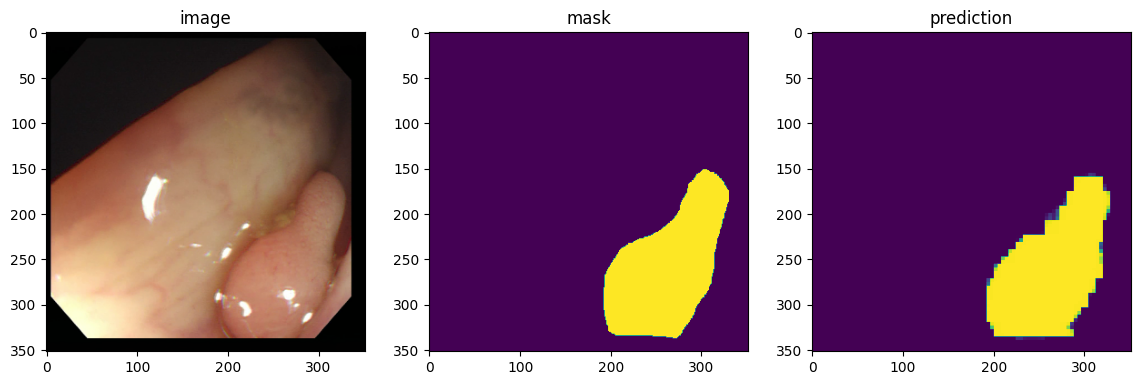

In [11]:
from torchmetrics import Dice
## preprocessing an image
def _load_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size[1], image_size[0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def _load_mask(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size[1], image_size[0]))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _,mask = cv2.threshold(gray,254,255,cv2.THRESH_BINARY)
    return np.expand_dims(mask, axis=-1)

def _totensor(tensor):
    totensor = transforms.Compose([transforms.ToTensor()]) ## convert NHWC to NCHW and resacaled to [0,1]
    return totensor(tensor)


if __name__ == "__main__":
    test_datasets = ['test', 'CVC-300', 'CVC-ClinicDB', 'Kvasir', 'CVC-ColonDB', 'ETIS-LaribPolypDB']
    # path='../CASCADE/data/polyp/dataset/TrainDataset/'
    path='../CASCADE/data/polyp/dataset/TestDataset/'
    image_size=(352,352)

    Dice_ = Dice().to(device)

    idx=0
    images = sorted(glob(path+test_datasets[idx]+'/images/*'))
    targets = sorted(glob(path+test_datasets[idx]+'/masks/*'))

    id=100
    loaded_image = _load_image(images[id])
    image = _totensor(loaded_image)
    image = image.unsqueeze(dim=0)

    target = _load_mask(targets[id])
    target = _totensor(target)
    target = target.unsqueeze(dim=0)

    out1, out2, out3, out4 = model(image)
    out = out1 + out2 + out3 + out4
    out = torch.sigmoid(out)
    out = (out - torch.min(out))/(torch.max(out)-torch.min(out))

    Dice_(out, target.type(torch.int64))
    dice = Dice_.compute()
    print(f'Dice: {dice}')
    print('\n')

    ## conver torch tensor to numpy array
    pred = torch.permute(out, (0,2,3,1)) ## NCHW
    pred = pred.detach().numpy()
    pred = np.squeeze(pred, axis=0)      ## HWC
    pred = pred*255
    pred = pred.astype(np.uint8)

    # mask = mask/255.
    mask = torch.permute(target, (0,2,3,1)) ## NCHW
    mask = mask.detach().numpy()
    mask = np.squeeze(mask, axis=0)      ## HWC
    mask = mask*255
    mask = mask.astype(np.uint8)

    plt.figure(figsize=(14,14))
    plt.subplot(1,3,1)
    plt.imshow(loaded_image)
    plt.title('image')
    plt.subplot(1,3,2)
    plt.imshow(mask)
    plt.title('mask')
    plt.subplot(1,3,3)
    plt.imshow(pred)
    plt.title('prediction')


Dice[image1]: 0.02560032531619072
Dice[image2]: 0.8991888761520386
Dice[image3]: 0.7264523506164551
Dice[image4]: 0.47725072503089905
Dice[image5]: 0.4353383481502533


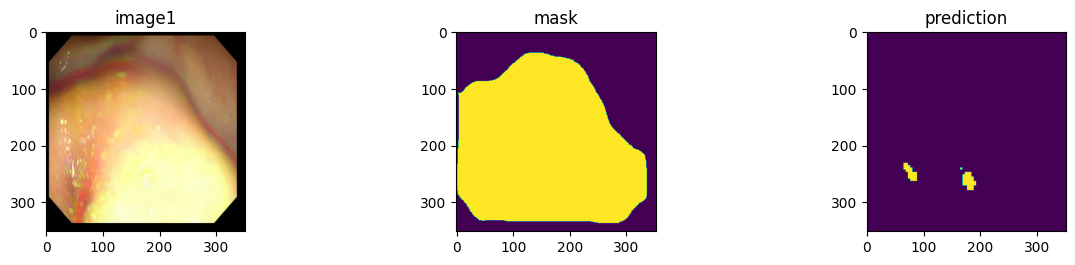

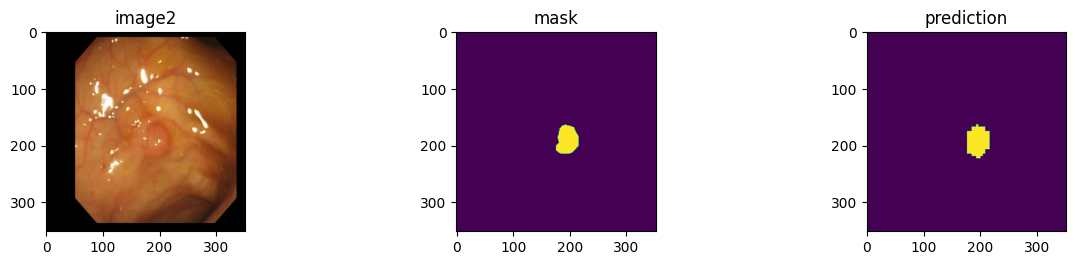

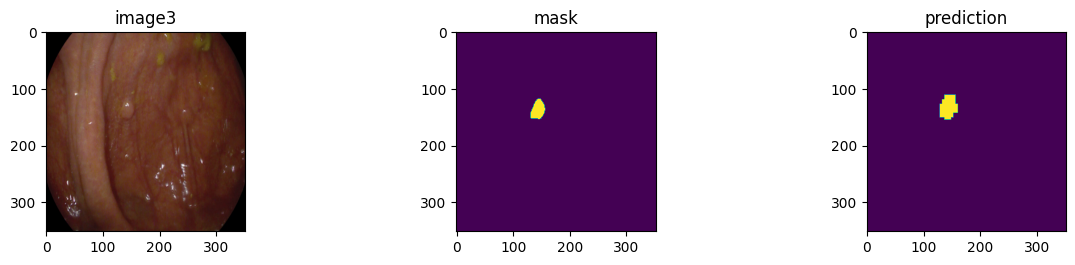

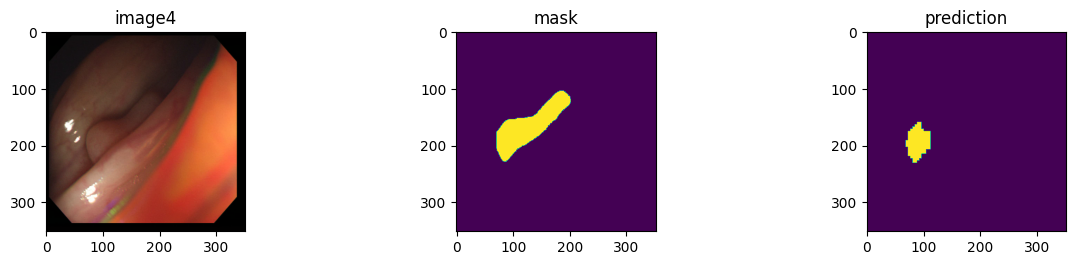

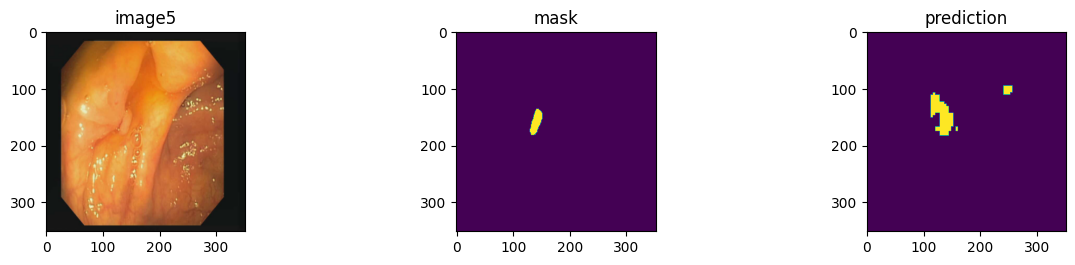

In [ ]:
from torchmetrics import Dice
## preprocessing an image
def _load_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size[1], image_size[0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def _load_mask(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size[1], image_size[0]))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _,mask = cv2.threshold(gray,254,255,cv2.THRESH_BINARY)
    return np.expand_dims(mask, axis=-1)

def _totensor(tensor):
    totensor = transforms.Compose([transforms.ToTensor()]) ## convert NHWC to NCHW and resacaled to [0,1]
    return totensor(tensor)


test_datasets = ['test', 'CVC-300', 'CVC-ClinicDB', 'Kvasir', 'CVC-ColonDB', 'ETIS-LaribPolypDB']
# path='../CASCADE/data/polyp/dataset/TrainDataset/'
path='../CASCADE/data/polyp/dataset/TestDataset/'
image_size=(352,352)

Dice_ = Dice().to(device)

idx=0
images = sorted(glob(path+test_datasets[idx]+'/images/*'))
targets = sorted(glob(path+test_datasets[idx]+'/masks/*'))

import random
n=5
r = random.sample(range(0, len(targets)), n)

for k, id in enumerate(r):
    loaded_image = _load_image(images[id])
    image = _totensor(loaded_image)
    image = image.unsqueeze(dim=0)

    target = _load_mask(targets[id])
    target = _totensor(target)
    target = target.unsqueeze(dim=0)

    out1, out2, out3, out4 = model(image)
    out = out1 + out2 + out3 + out4
    out = torch.sigmoid(out)
    out = (out - torch.min(out))/(torch.max(out)-torch.min(out))

    dice = Dice_(out, target.type(torch.int64))
    print(f'Dice[image{k+1}]: {dice}')

    ## conver torch tensor to numpy array
    pred = torch.permute(out, (0,2,3,1)) ## NCHW
    pred = pred.detach().numpy()
    pred = np.squeeze(pred, axis=0)      ## HWC
    pred = np.where(pred >= 0.5, 1, 0)
    pred = pred*255
    pred = pred.astype(np.uint8)

    # mask = mask/255.
    mask = torch.permute(target, (0,2,3,1)) ## NCHW
    mask = mask.detach().numpy()
    mask = np.squeeze(mask, axis=0)      ## HWC
    mask = mask*255
    mask = mask.astype(np.uint8)

    plt.figure(figsize=(15,15))
    plt.subplot(n,3,1)
    plt.imshow(loaded_image)
    plt.title('image'+str(k+1))
    plt.subplot(n,3,2)
    plt.imshow(mask)
    plt.title('mask')
    plt.subplot(n,3,3)
    plt.imshow(pred)
    plt.title('prediction')

In [12]:
## travelling on train dataset
from tqdm import tqdm

path='../CASCADE/data/polyp/dataset/TrainDataset/'
image_size=(352,352)

Dice_ = Dice().to(device)

images = sorted(glob(path+'images/*'))
targets = sorted(glob(path+'masks/*'))

dice_dict={}
for idx in tqdm(range(len(images)), ncols = 100, desc='train-set evaluation:'):
    loaded_image = _load_image(images[idx])
    image = _totensor(loaded_image)
    image = image.unsqueeze(dim=0)

    target = _load_mask(targets[idx])
    target = _totensor(target)
    target = target.unsqueeze(dim=0)

    out1, out2, out3, out4 = model(image)
    out = out1 + out2 + out3 + out4
    out = torch.sigmoid(out)
    out = (out - torch.min(out))/(torch.max(out)-torch.min(out))

    dice = Dice_(out, target.type(torch.int64))

    dice_dict[images[idx].split('/')[-1]]=dice

train-set evaluation:: 100%|████████████████████████████████████| 1450/1450 [32:57<00:00,  1.36s/it]


In [ ]:
d = {k: v for k, v in sorted(dice_dict.items(), key=lambda item: item[1])}
d.values()

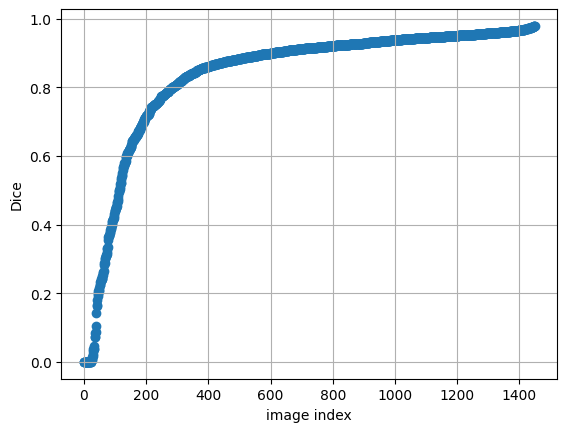

In [35]:
'''300 sample images is under 80% Dice score
   200 sample images is under 70% Dice score
   100 sample images is under 40% dice score'''
values = [k.item() for k in d.values()]
values
index = [i for i in range(len(values))]
plt.scatter(index, values)
plt.ylabel('Dice')
plt.xlabel('image index')
plt.grid()

plt.show()

In [37]:
import csv

with open('dice_dict.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in d.items():
       writer.writerow([key, value.item()])

In [45]:
values_ = [k.item() for k in d.values()]
keys_ = [k for k in d.keys()]

dd={}
dd['ids']=keys_
dd['dice']=values
df = pd.DataFrame(dd)

,ids,dice
0,125.png,0.000000
1,126.png,0.000000
2,135.png,0.000000
3,188.png,0.000000
4,204.png,0.000000
...,...,...
1445,138.png,0.976646
1446,cju8dn0c3u2v50801k8rvq02f.png,0.976777
1447,cju2xf8e5y2wm08359vcgk09b.png,0.976923
1448,cju3wstckialg0871xs0vevsj.png,0.977639


In [46]:
# df.to_csv('dice_dict.zip', index=False)

In [48]:
pd.read_csv('dice_dict.csv')

,125.png,0.0
0,126.png,0.000000
1,135.png,0.000000
2,188.png,0.000000
3,204.png,0.000000
4,386.png,0.000000
...,...,...
1444,138.png,0.976646
1445,cju8dn0c3u2v50801k8rvq02f.png,0.976777
1446,cju2xf8e5y2wm08359vcgk09b.png,0.976923
1447,cju3wstckialg0871xs0vevsj.png,0.977639


import numpy as np
from google.colab import autoviz
df_4609070368439591656 = autoviz.get_df('df_4609070368439591656')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_4609070368439591656, *['0.0'], **{})
chart

import numpy as np
from google.colab import autoviz
df_8531245394025789454 = autoviz.get_df('df_8531245394025789454')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_8531245394025789454, *['0.0'], **{})
chart

import numpy as np
from google.colab import autoviz
df_8950321976332083213 = autoviz.get_df('df_8950321976332083213')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_8950321976332083213, *['0.0', 'count()', None], **{})
chart